In [43]:
import pandas as pd
import numpy as np

In [44]:
file_path = '../../data/raw_daily_data_201001_202101.csv'

In [45]:
data = pd.read_csv(file_path, parse_dates=['Date'])
data.set_index('Date', inplace = True)

In [46]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,112.769997,112.800003,111.389999,111.440002,89.568359,90637900
2010-01-04,112.370003,113.389999,111.510002,113.330002,91.087418,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,91.328552,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,91.392838,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,91.778671,131091100


Daily Returns: Day-To-Day Percentage Change

In [47]:
data['Day_Perc_Change'] = data['Adj Close'].pct_change()*100
data.dropna(axis=0, inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Day_Perc_Change
Date,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,91.087418,118944600,1.695976
2010-01-05,113.260002,113.680000,112.849998,113.629997,91.328552,111579900,0.264729
2010-01-06,113.519997,113.989998,113.430000,113.709999,91.392838,116074400,0.070389
2010-01-07,113.500000,114.330002,113.180000,114.190002,91.778671,131091100,0.422171
2010-01-08,113.889999,114.620003,113.660004,114.570000,92.084045,126402800,0.332729


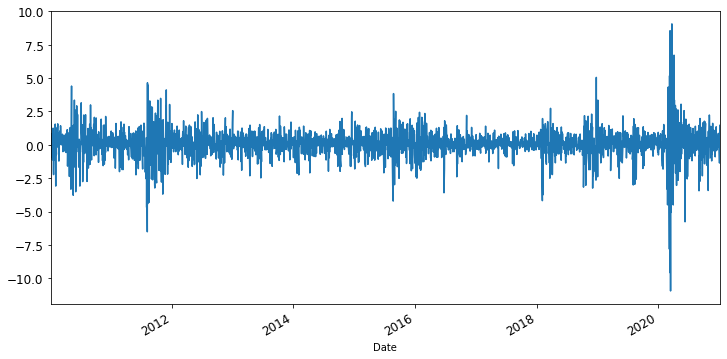

In [48]:
data['Day_Perc_Change'].plot(figsize = (12, 6), fontsize = 12)

Volitility Analysis

In [49]:
vol = data['Adj Close'].rolling(7).std()*np.sqrt(7)

In [50]:
data = data.assign(Volatility=vol)

In [54]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Day_Perc_Change,Volatility
Date,,,,,,,,
2021-01-04,375.309998,375.450012,364.820007,368.790009,368.790009,110210800,-1.361398,5.999279
2021-01-05,368.100006,372.500000,368.049988,371.329987,371.329987,66426200,0.688733,4.766402
2021-01-06,369.709991,376.980011,369.119995,373.549988,373.549988,107997700,0.597851,4.441927
2021-01-07,376.100006,379.899994,375.910004,379.100006,379.100006,68766800,1.485750,8.510109
2021-01-08,380.589996,381.489990,377.100006,381.260010,381.260010,71677200,0.569771,11.669939


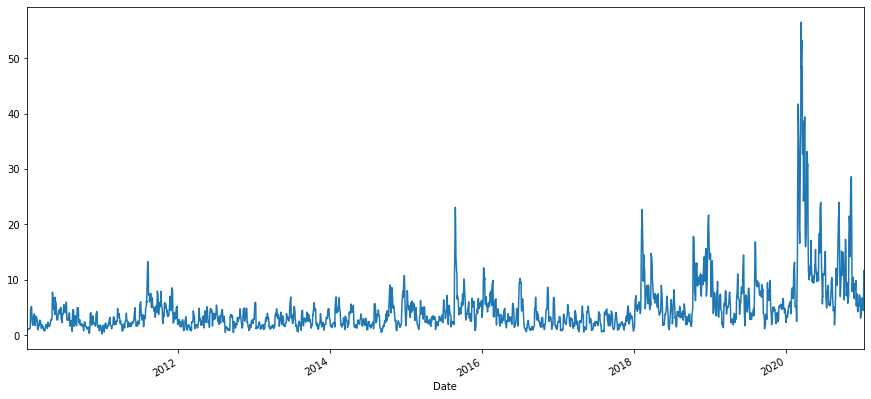

In [51]:
data.Volatility.plot(figsize=(15,7))

In [52]:
data.to_csv('data_vol.csv')